# First order Inch-worm test

Solving a non-interacting fermionic dimer system by hybridization expansion of one of the sites (here called the "bath" site).

In [1]:
import Test.@test
import KeldyshED; op = KeldyshED.Operators;

┌ Info: Precompiling KeldyshED [675b6b9c-7c2f-11e9-3bf3-dfd4d61640f7]
└ @ Base loading.jl:1278
┌ Warning: Package KeldyshED does not have Keldysh in its dependencies:
│ - If you have KeldyshED checked out for development and have
│   added Keldysh as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KeldyshED
└ Loading Keldysh into KeldyshED from project dependency, future warnings for KeldyshED are suppressed.


In [2]:
β = 10. # Inverse temperature

μ = 0.1 # Chemical potential
V = -0.1 # Hybridization
ε = 0.1 # Bath site energy

H = - μ * op.n("0")
H_bath = ε * op.n("1")
H_hyb = V*(op.c_dag("0")*op.c("1") + op.c_dag("1")*op.c("0")) 

H_dimer = H + H_hyb + H_bath

println("H = $H")
println("H_dimer = $H_dimer")

H = -0.1*c†("0")c("0")
H_dimer = -0.1*c†("0")c("1") + -0.1*c†("0")c("0") + 0.1*c†("1")c("1") + -0.1*c†("1")c("0")


## Real-time contour

In [3]:
import Keldysh; kd = Keldysh;

# Real-time Kadanoff-Baym contour

contour = kd.twist(kd.Contour(kd.full_contour, tmax=100., β=β));
grid = kd.TimeGrid(contour, npts_real=100, npts_imag=100);

## Bath hybridization function $\Delta(z, z')$

In [4]:
import KeldyshED; ked = KeldyshED;
import KeldyshED.Hilbert;
import KeldyshED; op = KeldyshED.Operators;

soi_bath = KeldyshED.Hilbert.SetOfIndices([["1"]])
ed_bath = KeldyshED.EDCore(H_bath, soi_bath)
    
# Bath hybridization function Δ(z, z')

bidx = KeldyshED.Hilbert.IndicesType(["1"])
g_bath = KeldyshED.computegf(ed_bath, grid, [(bidx, bidx)], β)[1];
Δ = V * g_bath * V;

In [5]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [6]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

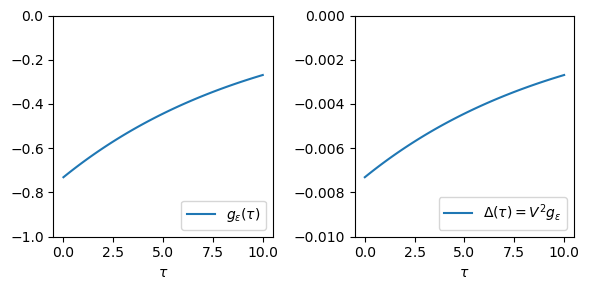

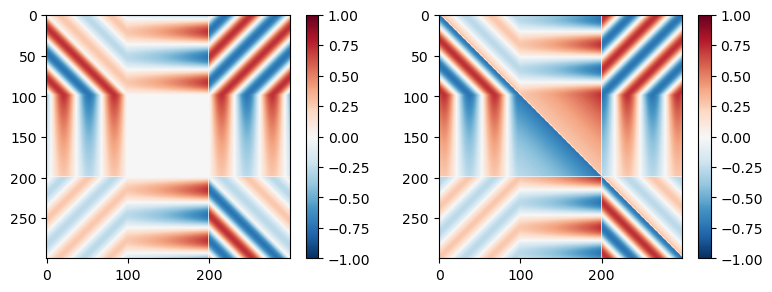

In [7]:
τ = kd.imagtimes(grid)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(τ, g_bath[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plt.subplot(1, 2, 2)
plt.plot(τ, Δ[:matsubara], label=plt.L"$\Delta(\tau) = V^2 g_\varepsilon$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-0.01, 0]);
plt.tight_layout()

plt.figure()
plot2d(g_bath.data)

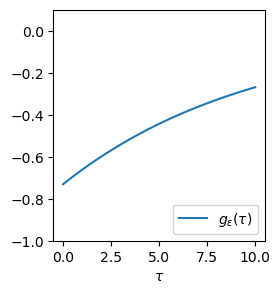

In [8]:
τ = kd.imagtimes(grid)

tau_grid = grid[kd.imaginary_branch]

τ_0 = tau_grid[1]
τ_beta = tau_grid[end]

g = g_bath[τ_0.idx:τ_beta.idx, τ_0.idx]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(τ, imag(g), label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0.1]);

## Bare pseudo-particle propagator

In [18]:
import QInchworm.ppgf: atomic_ppgf

soi = KeldyshED.Hilbert.SetOfIndices([["0"]])
ed = KeldyshED.EDCore(H, soi)

println(ed)

G0 = atomic_ppgf(grid, ed, β)


Dimension of full Hilbert space: 2
Number of invariant subspaces: 2
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.1]
Ground state energy: -0.1



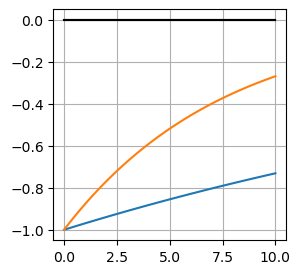

In [19]:
plt.figure(figsize=(3, 3))
for G0_s in G0
    g0_s = G0_s[kd.imaginary_branch, kd.imaginary_branch]
    g0_s = vcat(g0_s[:, 1]...)
        
    plt.plot(τ, real(g0_s), "-k")
    plt.plot(τ, imag(g0_s))
end
plt.grid(true)

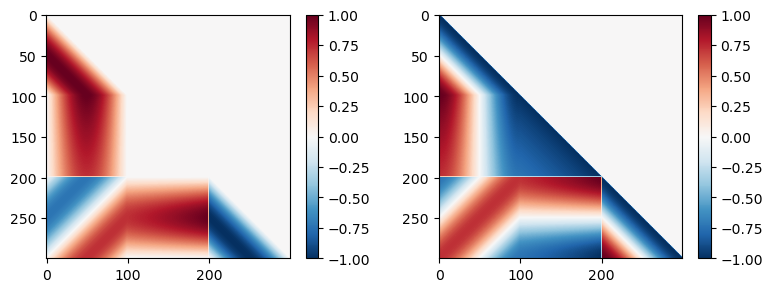

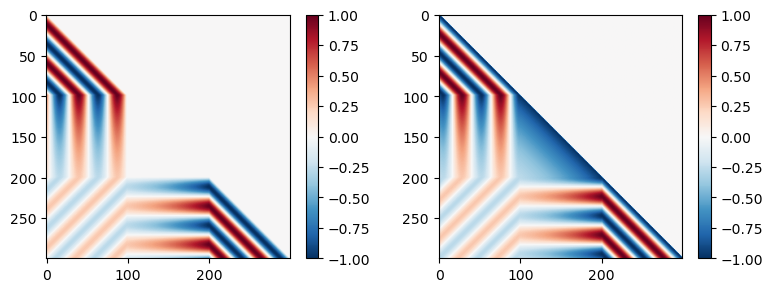

In [20]:
plt.figure(); plot2d(G0[1].data[1, 1, :, :])
plt.figure(); plot2d(G0[2].data[1, 1, :, :])

# Imaginary time translational invariance 

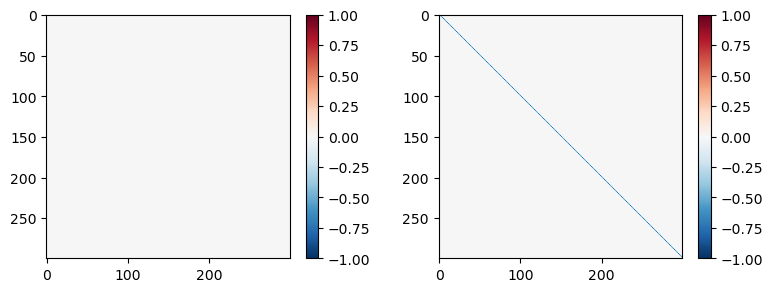

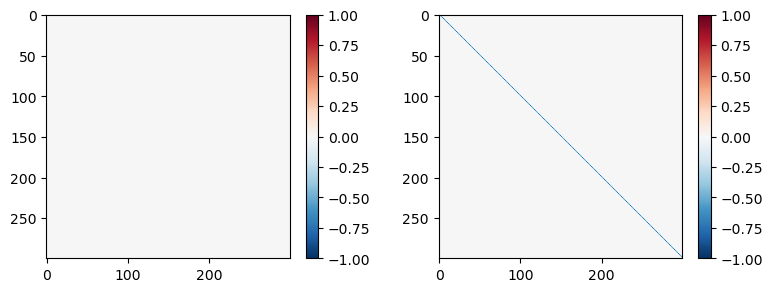

In [23]:
import QInchworm.ppgf: set_matsubara, set_ppgf_initial_conditions

G = copy(G0)

for G_s in G 
    G_s.data .*= 0.
end

set_ppgf_initial_conditions(G)

plt.figure(); plot2d(G[1].data[1, 1, :, :])
plt.figure(); plot2d(G[2].data[1, 1, :, :])

# Inch-worm configuration evaluator

In [ ]:
import KeldyshED: EDCore
import KeldyshED: c_connection, cdag_connection
import KeldyshED: c_matrix, cdag_matrix

function operator_product(ed::EDCore, G, s_i::Integer, z_i, z_f, vertices)

    length(vertices) == 0 && return G[s_i][z_f, z_i], s_i

    s_a = s_i
    (z_a, c_a, o_a) = vertices[1]

    prod0 = im * G[s_a][z_a, z_i]
    prod = prod0

    for (vidx, (z_a, c_a, o_a)) in enumerate(vertices)

        connection = c_a > 0 ? cdag_connection : c_connection
        matrix = c_a > 0 ? cdag_matrix : c_matrix

        s_b = connection(ed, o_a, s_a)
        s_b == nothing && return 0 * prod0, -1

        m_ba = matrix(ed, o_a, s_a)

        if vidx < length(vertices)
            z_b = vertices[vidx + 1][1]
        else
            z_b = z_f
        end

        prod = im * G[s_b][z_b, z_a] * m_ba * prod

        s_a = s_b
    end

    prod, s_a
end;

## First order Inch-worm approximation

The dressed pseudo-particle propagator has the form

$$
G(\tau_f - 0) = 
G_0(\tau_f - \tau_w) \cdot G(\tau_w - 0) 
\\ + 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger_a(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c_b(\tau_1) G(\tau_1 - 0)
\right]
\\ 
+ 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c_b(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c^\dagger_a(\tau_1) G(\tau_1 - 0)
\right]
$$

NB! To get the Matsubara component of $\Delta(\tau)$ from `Keldysh.jl` the values have to be scaled with $(-i)$

Here we restrict $\tau_f$ and $\tau_w$ (worm-time) to always be separated by a single time step, i.e. $\tau_f - \tau_w = \Delta \tau$.

The integrals are approximated using first order Riemann summation according to 

$$
\int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
\\
\approx
(\Delta \tau)^2 \sum_{\tau_1=0}^{\tau_w} \, 
(-i)\Delta(\tau_f - \tau_1)
\left[ 
 c^\dagger(\tau_f) G_0(\tau_f - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
$$

In [ ]:
tau_grid = grid[kd.imaginary_branch]

τ_0 = tau_grid[1]
τ_beta = tau_grid[end]

oidx = KeldyshED.Hilbert.IndicesType(["0"]);

for (s0, G_s) in enumerate(G)
    val = G0[s0][τ_0, τ_0]
    set_matsubara(G_s, grid, τ_0, val)
end

Δτ = -imag(tau_grid[2].val.val - tau_grid[1].val.val)
#println("Δτ = $(Δτ)")

for (fidx, τ_f) in enumerate(tau_grid[2:end])
    τ_w = tau_grid[fidx]
    #println("τ_f = $(τ_f.idx), τ_w = $(τ_w.idx)")

    for (s0, G_s) in enumerate(G)
        #print("  s0 = $(s0)\n    ")
        
        # Zeroth order contrib
        val = -im * im^2 * G0[s0][τ_f, τ_w] * G[s0][τ_w, τ_0]
        
        # First order contrib -- verticies at τ_f and τ_1
        for τ_1 in tau_grid[1:fidx]
            #print("$(τ_1.idx) ")
            
            # FWD hyb ins: \beta --c+--\tau_w--c-- \tau
            let (p1, s1) = operator_product(ed, G, s0, τ_0, τ_w, [(τ_1, -1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G0, s1, τ_w, τ_f, [(τ_f, +1, oidx)])
                    if s2 == s0
                        val += Δτ^2 * p2 * p1 * Δ[τ_f, τ_1]
                    end
                end
            end
            
            # BWD hyb ins: \beta --c--\tau_w--c+-- \tau
            let (p1, s1) = operator_product(ed, G, s0, τ_0, τ_w, [(τ_1, +1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G0, s1, τ_w, τ_f, [(τ_f, -1, oidx)])
                    if s2 == s0
                        val += -Δτ^2 * p2 * p1 * Δ[τ_1, τ_f]
                    end
                end
            end
            
        end # τ_1

        set_matsubara(G_s, τ_f, val)

    end # s0
end # τ_f

In [ ]:
import LinearAlgebra: tr
function get_Q(G)
    Q = 0
    for (s, G_s) in enumerate(G)
        g_s = G_s[kd.imaginary_branch, kd.imaginary_branch]
        g_s = vcat(g_s[:, 1]...)
        Q += im * tr(g_s[end])
    end
    Q
end;

function normalize_matsubara(G, β)
    Q = get_Q(G)
    λ = log(Q) / β
    tau_grid = grid[kd.imaginary_branch]
    τ_0 = tau_grid[1]
    for (idx, τ) in enumerate(tau_grid)
        for (s, G_s) in enumerate(G)
            val = G[s][τ, τ_0] .* exp(-1im * τ.val.val * λ)
            set_matsubara(G_s, grid, τ, val)
        end
    end
    G
end;

Q0 = get_Q(G0)
Q = get_Q(G)

println("Q0 = $Q0")
println("Q = $Q")

G = normalize_matsubara(G, β)
Q = get_Q(G)
println("Q = $Q")


In [ ]:
plt.figure(figsize=(6, 6))

for (s, G0_s) in enumerate(G0)
    g0_s = G0_s[kd.imaginary_branch, kd.imaginary_branch]
    g0_s = vcat(g0_s[:, 1]...)
    plt.plot(τ, -imag(g0_s), "--", label="-Im[G0_$(s)]")
    plt.plot(τ, real(g0_s), "-k")
end

for (s, G_s) in enumerate(G)
    g_s = G_s[kd.imaginary_branch, kd.imaginary_branch]
    g_s = vcat(g_s[:, 1]...)
    #plt.plot(τ, real(g_s), "-", label="G_$(s)")
    #plt.plot(τ, imag(g_s), "-k")
    plt.plot(τ, -imag(g_s), "-", label="-Im[G_$(s)]")
    plt.plot(τ, real(g_s), "-k")
end

plt.xlabel(plt.L"$\tau$")
plt.ylabel(plt.L"$\hat{G}(\tau)$");
plt.legend(); 
#plt.ylim([0, 1.1]);
plt.grid(true)

In [ ]:
plot2d(G0[1].data[1, 1, :, :])

In [ ]:
plot2d(G0[2].data[1, 1, :, :])

In [ ]:
plot2d(G[1].data[1, 1, :, :])

In [ ]:
plot2d(G[2].data[1, 1, :, :])

In [ ]:
plot2d(g_bath.data)